<a href="https://colab.research.google.com/github/DenyT17/Football_Object_Detection/blob/main/Football_Object_Detection_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Football tracking detection with YOLOv8 and BYTETracker**


## **Installing required libraries**


In [3]:
!pip install ultralytics
from __future__ import annotations
import math
from typing import Generator
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
import cv2 as cv
from google.colab import drive
import os
import numpy as np
%matplotlib inline
from ultralytics import YOLO
from dataclasses import dataclass, field
import math
import numpy as np
from typing import Tuple, Optional, List, Dict, Any
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.0/511.0 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 25.6 MB/s eta 0:00:00


## **Connecting with google drive**

In [ ]:
drive.mount('/content/gdrive')

ROOT_DIR = '/content/gdrive/My Drive/Football_Detection'

Mounted at /content/gdrive


## **Loading an early trained model**

In [14]:
model = YOLO("/content/drive/MyDrive/Football_Detection/runs/detect/train2/weights/best.pt")

## **Loading image and video**

In [ ]:
video = "/content/gdrive/My Drive/Football_Detection/video/finall"
img = cv.imread("/content/gdrive/My Drive/Football_Detection/test/images/573e61_9_6_png.rf.f7756714cdfe79da92e3e99837b7b655.jpg")

## **Defining classes, methods and functions which will be used to objects detection**

In [ ]:
@dataclass(frozen=True)
class Rect:
    x: float
    y: float
    width: float
    height: float

@dataclass
class Detection:
    rect:Rect
    class_id: int
    class_name: str
    confidence: float
    tracker_id: Optional[int] = None

    @classmethod
    def from_results(cls, pred: np.ndarray, names: List[str]) -> List[Detection]:
        result = []
        for r in pred:
          boxes = r.boxes
          for box in boxes:
            class_id = int(box.cls[0])
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            result.append(Detection(
                rect=Rect(
                    x=float(x1),
                    y=float(y1),
                    width=float(x2 - x1),
                    height=float(y2 - y1)
                ),
                class_id=class_id,
                class_name=names[class_id],
                confidence=math.ceil((box.conf[0] * 100)) / 100
            ))
        return result
  

In [ ]:
@dataclass(frozen=True)
class Color:
    r: int
    g: int
    b: int
        
    @property
    def bgr_tuple(self) -> Tuple[int, int, int]:
        return self.b, self.g, self.r

def draw_shape(image: np.ndarray, rect: Rect,conf: float,name: str, color: Color, thickness: int = 2) -> np.ndarray:
  bottom_center_x = int(rect.x + rect.width/2)
  bottom_center_y = int(rect.y + rect.height)
  cv.ellipse(
      image,
      center=(bottom_center_x,bottom_center_y),
      axes=(int(rect.width), int(0.4 * rect.width)),
      angle=0.0,
      startAngle=-45,
      endAngle=235,
      color=color,
      thickness=thickness,
      lineType=cv.LINE_4
  )


  return image

Ball_posesion_range = 30
MARKER_CONTOUR_THICKNESS = 2
MARKER_WIDTH = 20
MARKER_HEIGHT = 20
MARKER_MARGIN = 10

def calculate_marker(x: int,y:int) -> np.ndarray:
    return(np.array([
        [x - MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN],
        [x, y - MARKER_MARGIN],
        [x + MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN]
    ]))


def draw_polygon(image: np.ndarray, countour: np.ndarray, color: Color, thickness: int = 2) -> np.ndarray:
    cv.drawContours(image, [countour], 0, color, thickness)
    return image

def draw_filled_polygon(image: np.ndarray, countour: np.ndarray, color: Color) -> np.ndarray:
    cv.drawContours(image, [countour], 0, color, -1)
    return image

def filter_detections_by_class(detections: List[Detection], class_name: str) -> List[Detection]:
    return [
        detection
        for detection 
        in detections
        if detection.class_name == class_name
    ]

def ball_in_posesion(x_ball: int,y_ball: int, x_player: int,y_player: int, proximity: int):
  if x_player - proximity < x_ball <  x_player + proximity and y_player - proximity < y_ball <  y_player + proximity:
    return True
  else:
    return False

def get_player_in_possession(
    player_detections: List[Detection], 
    ball_detections: List[Detection],
    proximity: int) -> Optional[Detection]:
    if len(ball_detections) != 1:
        return None
    ball_detection = ball_detections[0]
    x_ball,y_ball = int(ball_detection.rect.x + ball_detection.rect.width/2),int(ball_detection.rect.y + ball_detection.rect.height)
    for player_detection in player_detections:
      x_player,y_player = int(player_detection.rect.x + player_detection.rect.width/2), int(player_detection.rect.y + player_detection.rect.height)
      if ball_in_posesion(x_ball,y_ball, x_player,y_player, proximity):
        return player_detection

def draw_marker(image: np.ndarray,x: int,y: int, color: Color) -> np.ndarray:
    possession_marker_countour = calculate_marker(x,y)

    image = draw_filled_polygon(
        image=image, 
        countour=possession_marker_countour, 
        color=color)
    image = draw_polygon(
        image=image, 
        countour=possession_marker_countour, 
        color=Ball_color,
        thickness=MARKER_CONTOUR_THICKNESS)
    return image

In [ ]:
@dataclass
class BaseAnnotator:
    colors: Color
    thickness: int

    def annotate(self, image: np.ndarray, detections: List[Detection],player_with_posesion: Optional[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            top_center_x = int(detection.rect.x + detection.rect.width/2)
            top_center_y = int(detection.rect.y)
            annotated_image = draw_shape(
                image=image,
                rect=detection.rect,
                conf=detection.confidence,
                name=detection.class_name,
                color=self.colors[detection.class_id],
                thickness=self.thickness)
            
            
            if detection == player_with_posesion:
              annotated_image = draw_marker(
                  image=annotated_image, 
                  x=top_center_x,
                  y=top_center_y,
                  color=self.colors[detection.class_id])
              
            if detection.class_name == "ball":
              annotated_image = draw_marker(
                  image=annotated_image, 
                  x=top_center_x,
                  y=top_center_y,
                  color=self.colors[detection.class_id])
  
        return annotated_image

def plot_image(image: np.ndarray, size: int = 12) -> None:
  plt.figure(figsize=(size, size))
  plt.imshow(image[...,::-1])
  plt.show()

## **Detection of objects in the image**

In [ ]:
prediction = model(img)
detections = Detection.from_results(
    pred=prediction,
    names=model.names)
print(detections)


0: 640x640 1 goalkeeper, 17 players, 4 referees, 16.3ms
Speed: 0.7ms preprocess, 16.3ms inference, 16.4ms postprocess per image at shape (1, 3, 640, 640)


[Detection(rect=Rect(x=1212.0, y=1159.0, width=35.0, height=110.0), class_id=3, class_name='referee', confidence=0.91, tracker_id=None), Detection(rect=Rect(x=290.0, y=950.0, width=31.0, height=84.0), class_id=2, class_name='player', confidence=0.91, tracker_id=None), Detection(rect=Rect(x=586.0, y=584.0, width=17.0, height=57.0), class_id=2, class_name='player', confidence=0.9, tracker_id=None), Detection(rect=Rect(x=659.0, y=493.0, width=16.0, height=51.0), class_id=2, class_name='player', confidence=0.89, tracker_id=None), Detection(rect=Rect(x=821.0, y=857.0, width=31.0, height=79.0), class_id=2, class_name='player', confidence=0.89, tracker_id=None), Detection(rect=Rect(x=1089.0, y=655.0, width=16.0, height=72.0), class_id=2, class_name='player', confidence=0.88, tracker_id=None), Detection(rect=Rect(x=453.0, y=532.0, width=15.0, height=56.0), class_id=2, class_name='player', confidence=0.88, tracker_id=None), Detection(rect=Rect(x=745.0, y=814.0, width=33.0, height=74.0), class_i

## **Annotating object and showing results**

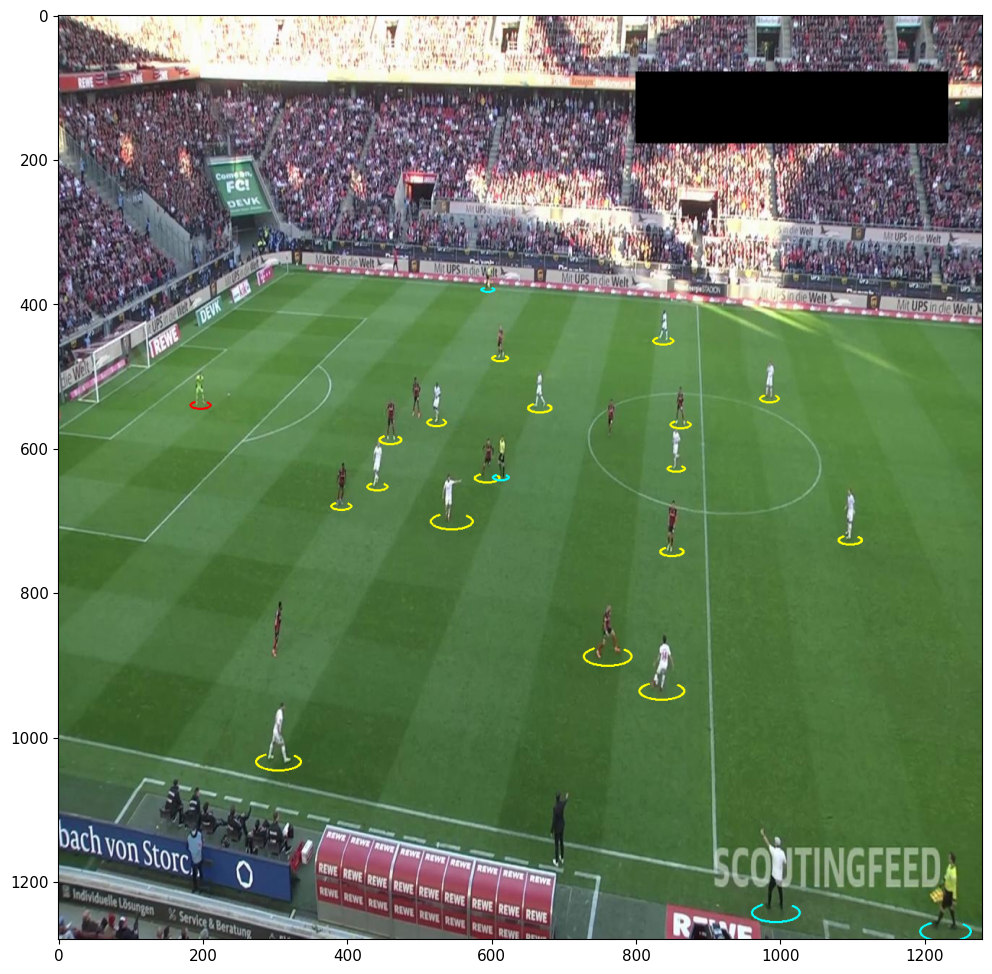

In [ ]:

Ball_color = (255,0,0)
Goalkeeper_color = (0,0,255)
Players_color = (0,255,255)
Refrees_color = (255,255,0)

ball_detections = filter_detections_by_class(detections=detections, class_name="ball")
player_detections = filter_detections_by_class(detections=detections, class_name="player")
player_in_possession_detection = get_player_in_possession(
            player_detections=player_detections,
            ball_detections=ball_detections,
            proximity=Ball_posesion_range
            )
Colors = [
    Ball_color,
    Goalkeeper_color,
    Players_color,
    Refrees_color   
]

annotator = BaseAnnotator(
    colors=Colors, 
    thickness=2)

image_with_detection = annotator.annotate(
    image=img, 
    detections=detections,
    player_with_posesion = player_in_possession_detection)

plot_image(image_with_detection)

## **Detection and annotating of objects in the video, and create new video with detected objects.**

In [ ]:
def pred_and_save(video:str):
    video_path = os.path.join(f"{video}.mp4")
    video_path_out = '{}_out.mp4'.format(video)

    cap = cv.VideoCapture(video_path)
    ret, frame = cap.read()
    H, W, _ = frame.shape
    out = cv.VideoWriter(video_path_out, cv.VideoWriter_fourcc(*'MP4V'), int(cap.get(cv.CAP_PROP_FPS)), (W, H))
    classNames = ['ball', 'goalkeeper', 'player', 'referee']
    while ret:
        prediction = model(frame)
        detections = Detection.from_results(pred=prediction,names=model.names)
        ball_detections = filter_detections_by_class(detections=detections, class_name="ball")
        player_detections = filter_detections_by_class(detections=detections, class_name="player")
        player_in_possession_detection = get_player_in_possession(
            player_detections=player_detections,
            ball_detections=ball_detections,
            proximity=Ball_posesion_range
            )
        annotator = BaseAnnotator(colors=Colors, thickness=2)
        image_with_detection = annotator.annotate(image=frame, detections=detections,player_with_posesion = player_in_possession_detection)
        out.write(image_with_detection)
        ret, frame = cap.read()
    cap.release()
    out.release()
    cv.destroyAllWindows()
    print(f"{video_path_out} saved")

pred_and_save(video)



0: 384x640 1 goalkeeper, 19 players, 2 referees, 12.6ms
Speed: 0.6ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 goalkeeper, 19 players, 2 referees, 14.4ms
Speed: 0.6ms preprocess, 14.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 goalkeeper, 20 players, 2 referees, 17.2ms
Speed: 0.6ms preprocess, 17.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 goalkeeper, 17 players, 2 referees, 17.3ms
Speed: 0.8ms preprocess, 17.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 goalkeeper, 18 players, 2 referees, 12.8ms
Speed: 0.6ms preprocess, 12.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 goalkeeper, 19 players, 2 referees, 14.5ms
Speed: 0.6ms preprocess, 14.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 goalkeeper, 18 players, 2 referees, 11.9ms
Speed: 0.6ms prepro

/content/gdrive/My Drive/Football_Detection/video/finall_out.mp4 saved


# **Tracking objects**

In [ ]:
from dataclasses import dataclass

!git clone https://github.com/ifzhang/ByteTrack.git
!cd ByteTrack && pip3 install -r requirements.txt
!cd ByteTrack && python3 setup.py develop
!pip install cython_bbox

!pip install onemetric --quiet
!pip install loguru
!pip install utils
!pip install lap
!pip install yolox


Cloning into 'ByteTrack'...
remote: Enumerating objects: 2007, done.
remote: Total 2007 (delta 0), reused 0 (delta 0), pack-reused 2007
Receiving objects: 100% (2007/2007), 79.60 MiB | 3.53 MiB/s, done.
Resolving deltas: 100% (1141/1141), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 64.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 KB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 KB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 82.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Ins

In [ ]:
import sys
sys.path.append(f"/root/ByteTrack") 

In [ ]:
import torch
import utils
import lap
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch

ERROR: Invalid requirement: 'pycocotools\u200b\u200b'

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

-e option requires 1 argument
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ModuleNotFoundError: ignored

# **Converting detection into format that can be used in match detection with track** 

In [ ]:
def detections2boxes(detections: List[Detection], with_confidence: bool = True) -> np.ndarray:
    return np.array([
        [
            detection.rect.x, 
            detection.rect.y,
            detection.rect.x + detection.rect.width,
            detection.rect.y + detection.rect.height,
            detection.confidence
        ] if with_confidence else [
            detection.rect.x, 
            detection.rect.y,
            detection.rect.x + detection.rect.width,
            detection.rect.y + detection.rect.height,
        ]
        for detection
        in detections
    ], dtype=float)

def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
      track.tlbr
      for track
      in tracks
    ], dtype=float)

## **Function to match detection and tracking** 

In [ ]:
def match_detections_with_tracks(
    detections: List[Detection], 
    tracks: List[STrack]
) -> List[Detection]:
    detection_boxes = detections2boxes(detections=detections, with_confidence=False)
    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detection_boxes)
    track2detection = np.argmax(iou, axis=1)
    
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            detections[detection_index].tracker_id = tracks[tracker_index].track_id
    return detections

## **Creating class thank to which tracking text will be adding**

In [ ]:
@dataclass
class TrackAnnotator:
    background_color: Color
    text_color: Color
    text_thickness: int

    def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            if detection.tracker_id is None:
                continue

            size, _ = cv.getTextSize(
                str(detection.tracker_id), 
                cv.FONT_HERSHEY_SIMPLEX, 
                0.7, 
                thickness=self.text_thickness)
            width, height = size
            
            top_left_x = int(detection.rect.x)
            top_left_y = int(detection.rect.y - detection.rect.height/3)
            bottom_right_x = int(detection.rect.x + 40)
            bottom_right_y = int(detection.rect.y)

            annotated_image = cv.rectangle(annotated_image,
                                           (top_left_x,top_left_y), 
                                           (bottom_right_x,bottom_right_y),
                                           self.background_color, -1)

            annotated_image = cv.putText(annotated_image,
                                         str(detection.tracker_id),
                                         (top_left_x,bottom_right_y),
                                         cv.FONT_HERSHEY_SIMPLEX,
                                         0.7, self.text_color,
                                         self.text_thickness, 2, False)

        return annotated_image

@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## **Tracking object on single image**


0: 640x640 3 balls, 1 goalkeeper, 19 players, 4 referees, 20.8ms
Speed: 1.0ms preprocess, 20.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


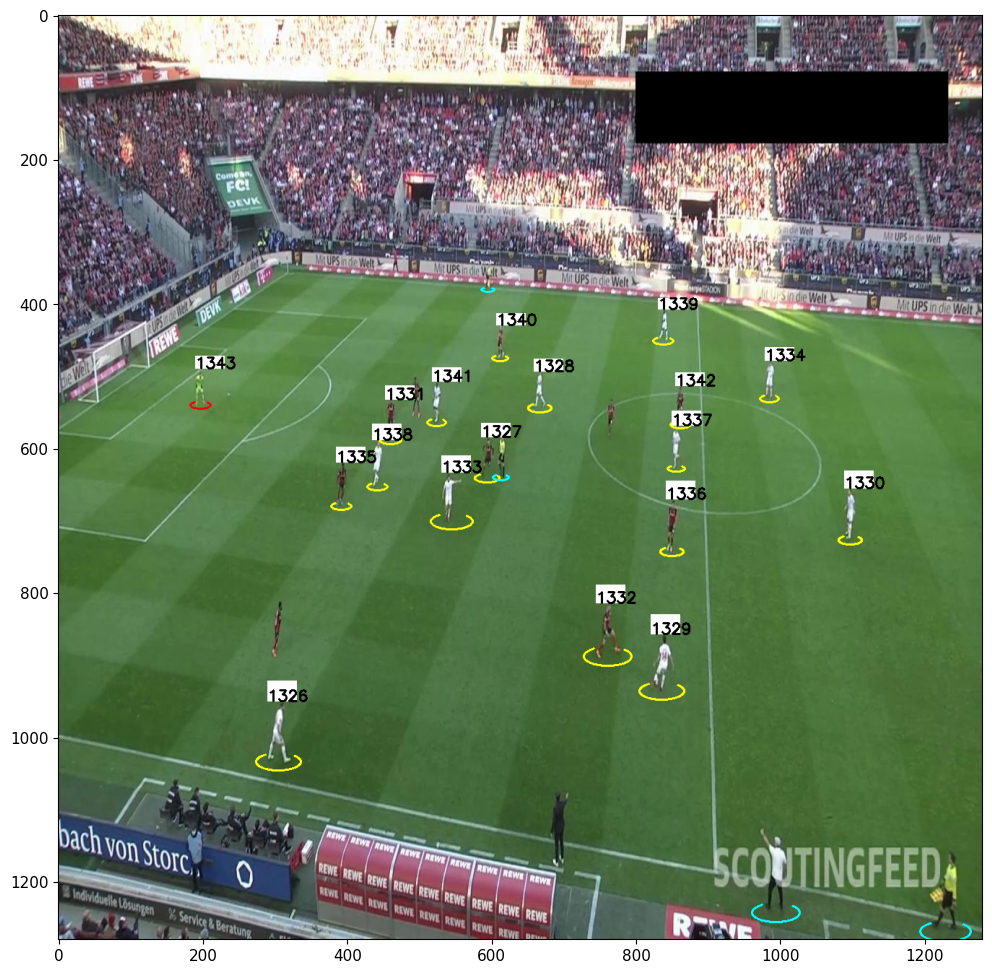

In [ ]:
def track_img(img: numpy.ndarray):
  byte_tracker = BYTETracker(BYTETrackerArgs())
  track_annotator = TrackAnnotator(background_color=(255, 255, 255), text_color=(0, 0, 0), text_thickness=2)

  results =  model(img)
  detections = Detection.from_results(
      pred=prediction,
      names=model.names)

  goalkeeper_detections = filter_detections_by_class(detections=detections, class_name="goalkeeper")
  player_detections = filter_detections_by_class(detections=detections, class_name="player")
  player_detections = player_detections + goalkeeper_detections
      
  tracks = byte_tracker.update(
        output_results=detections2boxes(detections=player_detections),
        img_info=img.shape,
        img_size=img.shape
      )
  player_detections = match_detections_with_tracks(detections=player_detections, tracks=tracks)


  annotated_image = img.copy()
  annotated_image = track_annotator.annotate(
        image=annotated_image, 
        detections=player_detections)
  plot_image(annotated_image)

track_img(img)

## **Saving video with detected and tracked objects**

In [ ]:

def save_video_det_tr(video:str):

    Ball_color = (255,0,0)
    Goalkeeper_color = (0,0,255)
    Players_color = (0,255,255)
    Refrees_color = (255,255,0)
    video_path = os.path.join(f"{video}.mp4")
    video_path_out = '{}_out.mp4'.format(video)

    byte_tracker = BYTETracker(BYTETrackerArgs())

    track_annotator = TrackAnnotator(background_color=(255, 255, 255), text_color=(0, 0, 0), text_thickness=2)

    cap = cv.VideoCapture(video_path)
    ret, frame = cap.read()
    H, W, _ = frame.shape
    out = cv.VideoWriter(video_path_out, cv.VideoWriter_fourcc(*'MP4V'), int(cap.get(cv.CAP_PROP_FPS)), (W, H))
    classNames = ['ball', 'goalkeeper', 'player', 'referee']
    while ret:
        prediction = model(frame)

        
        detections = Detection.from_results(pred=prediction,names=model.names)
        ball_detections = filter_detections_by_class(detections=detections, class_name="ball")
        player_detections = filter_detections_by_class(detections=detections, class_name="player")
        goalkeeper_detections = filter_detections_by_class(detections=detections, class_name="goalkeeper")

        player_in_possession_detection = get_player_in_possession(
            player_detections=player_detections,
            ball_detections=ball_detections,
            proximity=Ball_posesion_range
            )
        
        tracks = byte_tracker.update(
        output_results=detections2boxes(detections=player_detections),
        img_info=img.shape,
        img_size=img.shape
        )

        player_detections = match_detections_with_tracks(detections=player_detections, tracks=tracks)

        annotator = BaseAnnotator(colors=Colors, thickness=2)
        image_with_detection = annotator.annotate(image=frame, detections=detections,player_with_posesion = player_in_possession_detection)
        image_with_detection = track_annotator.annotate(
                                                        image=image_with_detection, 
                                                        detections=player_detections)
        out.write(image_with_detection)
        ret, frame = cap.read()
    cap.release()
    out.release()
    cv.destroyAllWindows()
    print(f"{video_path_out} saved")

save_video_det_tr(video)


0: 384x640 1 goalkeeper, 19 players, 2 referees, 36.4ms
Speed: 0.6ms preprocess, 36.4ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 goalkeeper, 19 players, 2 referees, 54.3ms
Speed: 0.6ms preprocess, 54.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 goalkeeper, 20 players, 2 referees, 29.5ms
Speed: 0.6ms preprocess, 29.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 goalkeeper, 17 players, 2 referees, 17.1ms
Speed: 0.5ms preprocess, 17.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 goalkeeper, 18 players, 2 referees, 26.2ms
Speed: 0.6ms preprocess, 26.2ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 goalkeeper, 19 players, 2 referees, 14.1ms
Speed: 0.6ms preprocess, 14.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 goalkeeper, 18 players, 2 referees, 18.3ms
Speed: 0.6ms prepro

/content/gdrive/My Drive/Football_Detection/video/finall_out.mp4 saved


# **Perspective transformation**

In [12]:
%cd "/content/drive/MyDrive/Football_Detection/perspective_transform"
!pip install -r requirements.txt
from elements.perspective_transform import Perspective_Transform
from elements.assets import transform_matrix, detect_color


import torch
import os
import cv2
import numpy as np
import sys

/content/drive/MyDrive/Football_Detection/perspective_transform
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
def main():
    # Load models
    perspective_transform = Perspective_Transform()

    # Video capture
    cap = cv2.VideoCapture(r"/content/drive/MyDrive/Football_Detection/video/finall.mp4")
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)

    w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

    # Save output
    if True:
        # output_name = opt.source.split('/')[-1]
        # output_name = output_name.split('.')[0] + '_output.' + output_name.split('.')[-1]

        # output_path = os.path.join(os.getcwd(), 'inference/output')
        # os.makedirs(output_path, exist_ok=True)
        # output_name = os.path.join(os.getcwd(), 'inference/output', output_name)
        output_name = os.path.join("/content/drive/MyDrive/Football_Detection/video/videoo.mp4")

        w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
        h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

        out = cv2.VideoWriter(output_name,  
                                cv2.VideoWriter_fourcc(*'mp4v'), 
                                opt.outputfps, (int(w), int(h)))


    frame_num = 0

    # Black Image (Soccer Field)
    bg_ratio = int(np.ceil(w/(3*115)))
    gt_img = cv2.imread('./inference/black.jpg')
    gt_img = cv2.resize(gt_img,(115*bg_ratio, 74*bg_ratio))
    gt_h, gt_w, _ = gt_img.shape


    while(cap.isOpened()):
        
        ret, frame = cap.read()
        bg_img = gt_img.copy()

        if ret:
            main_frame = frame.copy()
            yoloOutput = model(frame)

            # Output: Homography Matrix and Warped image 
            if frame_num % 5 ==0: # Calculate the homography matrix every 5 frames
                M, warped_image = perspective_transform.homography_matrix(main_frame)

            if yoloOutput:

                # Tracking
                deep_sort.detection_to_deepsort(yoloOutput, frame)

                # The homography matrix is applied to the center of the lower side of the bbox.
                for i, obj in enumerate(yoloOutput):
                    xyxy = [obj['bbox'][0][0], obj['bbox'][0][1], obj['bbox'][1][0], obj['bbox'][1][1]]
                    x_center = (xyxy[0] + xyxy[2])/2 
                    y_center = xyxy[3]
                    
                    if obj['label'] == 'player':
                        coords = transform_matrix(M, (x_center, y_center), (h, w), (gt_h, gt_w))
                        try:
                            color = detect_color(main_frame[xyxy[1]:xyxy[3], xyxy[0]:xyxy[2]])
                            cv2.circle(bg_img, coords, bg_ratio + 1, color, -1)
                        except:
                          pass
                    elif obj['label'] == 'ball':
                        coords = transform_matrix(M, (x_center, y_center), (h, w), (gt_h, gt_w))
                        cv2.circle(bg_img, coords, bg_ratio + 1, (102, 0, 102), -1)
                        plot_one_box(xyxy, frame, (102, 0, 102), label="ball")
            else:
                deep_sort.deepsort.increment_ages()

            frame[frame.shape[0]-bg_img.shape[0]:, frame.shape[1]-bg_img.shape[1]:] = bg_img  
            
            if opt.view:
                cv2.imshow('frame',frame)
                if cv2.waitKey(1) & ord('q') == 0xFF:
                    break

            # Saving the output
            if opt.save:
                out.write(frame)

            frame_num += 1
        else:
            break

        sys.stdout.write(
            "\r[Input Video : %s] [%d/%d Frames Processed]"
            % (
                opt.source,
                frame_num,
                frame_count,
            )
        )

    if opt.save:
        print(f'\n\nOutput video has been saved in {output_path}!')
    
    cap.release()
    cv2.destroyAllWindows()